In [1]:
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

from tqdm import tqdm

import numpy as np
import nibabel as nib
import concurrent.futures

from monai.data.utils import pad_list_data_collate

import monai.losses as losses
import matplotlib.pyplot as plt
from monai.networks.layers import Norm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import Transform
from monai.transforms import (
    AsDiscrete,
    Compose,
    SpatialPad,
    SpatialPadd,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandCropByLabelClassesd,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    NormalizeIntensity,
    NormalizeIntensityd,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
    RandGaussianNoised,
)


from monai.config import print_config
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.networks.nets import UNet

from monai.data import (
    DataLoader,
    ThreadDataLoader,
    SmartCacheDataset,
    PersistentDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)


import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR

from boundary_loss import BDLoss, DC_and_BD_loss

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.5
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/emmanuel/PycharmProjects/pythonProject/venv/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.5.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 4.7.1
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.5
pandas version: 1.3.5
einops version: 0.6.1
transformers version: 4.28.1
mlflow version: 1.30.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = 'Model'
model_name =  os.path.join(root_dir, "best_metric_model_with_boundry_loss.pth")
print(model_name)

Model/best_metric_model_with_boundry_loss.pth


In [4]:
class CombineBinaryMaps(Transform):
    def __init__(self, num_classes, keys):
        super().__init__()
        self.num_classes = num_classes

    def __call__(self, data):
        binary_maps = data["label"]
        combined_map = torch.zeros_like(data['image'][0])

        for i in range(self.num_classes):
            zero_indices = np.where(combined_map == 0)
            combined_map[zero_indices] += (i + 1) * binary_maps[i][zero_indices]
#             combined_map %= (self.num_classes + 1)

        data["label"] = combined_map.long().unsqueeze(0)
        return data

In [5]:
class MyCustomDataReader(Transform):
    def __init__(self, data_dir):
        self.data_dir = data_dir

    def __call__(self, img):
        # Load data from the data_dir
        file_path = os.path.join(self.data_dir, img)
        loaded_data = np.load(file_path)  # Customize this to your specific data format

        return loaded_data

In [6]:
num_samples = 4

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ToDo: Try windowing with W:350 and L:40
# define the window width and level
window_width = 350
window_level = 40

# calculate the intensity range to clip
intensity_min = window_level - window_width / 2.0
intensity_max = window_level + window_width / 2.0

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True, image_only=False),
        CombineBinaryMaps(keys=["label"], num_classes=10),
#         RandGaussianNoised(keys=["image"], prob=0.50, mean=0.0, std=0.1),

        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        SpatialPadd(
            spatial_size=(96, 96, 96),
            keys=["image", "label"]
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=False),
       
#         RandCropByLabelClassesd(
#             keys=["image", "label"],
#             label_key="label",
#             spatial_size=(96, 96, 96),
#             num_samples=num_samples,
#             num_classes=11,
#             image_key="image",
#             image_threshold=0,
#             allow_smaller=True
#         ),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
            allow_smaller=True
        ),

        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),

    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True, image_only=False),
        CombineBinaryMaps(keys=["label"], num_classes=10),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        SpatialPadd(
            spatial_size=(96, 96, 96),
            keys=["image", "label"]
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
    ]
)

# Load Dataset

In [7]:
def generate_file_path(root_path):
    all_files = os.listdir(root_path)
    return [{'image': f'{root_path}/{i}/ct.nii.gz',
             'label': [f'{root_path}/{i}/segments/{f}' for f in os.listdir(f'{root_path}/{i}/segments')],
#              'label': f'{root_path}/{i}/labels.nii.gz'

            } 
            for i in all_files if os.path.isfile(f'{root_path}/{i}/ct.nii.gz')]

def data_reader(file_addr):
    # load the image data
    image_read = nib.load(item["image"])
    image_data = image_read.get_fdata(dtype=np.float32)
    header = image_read.header
    # load the label data
    label_data = nib.load(item["label"]).get_fdata(dtype=np.float32)
    # Extract the metadata from the header
    metadata = {'dim': header.get_data_shape(),
                'pixdim': header.get_zooms(),
                'affine': header.get_qform()}
    data = {
        'image': image_data,
        'label': label_data,
        'metadata': metadata,
    }
    return data

In [8]:
root = 'Dataset'
file_list_train = generate_file_path(root_path=f'{root}/train')
file_list_val = generate_file_path(root_path=f'{root}/val')

In [9]:
def collate_fn(batch):
    transform = SpatialPad(
            (96, 96, 96),
        )
#     print([item for item in batch[0]])
    images = [transform(item["image"]) for item in batch[0]]
    labels = [transform(item["label"]) for item in batch[0]]
#     print(images.shape, labels.shape)
    return {"image": torch.stack(images),
           "label":torch.stack(labels)}

In [10]:
train_ds = PersistentDataset(
    data=file_list_train,
    transform=train_transforms,
    cache_dir='train_unet'
)

train_loader = ThreadDataLoader(train_ds, batch_size=1, shuffle=True,
                                collate_fn=lambda x: pad_list_data_collate(x, pad_to_shape=(96, 96, 96))
                               )

In [11]:
val_ds = PersistentDataset(
    data=file_list_val,
    transform=val_transforms,
    cache_dir='val'
#     cache_dir='C:/Training/val'
)

val_loader = ThreadDataLoader(val_ds, batch_size=1, 
                              collate_fn=lambda x: pad_list_data_collate(x, pad_to_shape=(96, 96, 96)))

# Model

In [12]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, loss):
        if self.best_loss is None:
            self.best_loss = loss
        else:
            if (self.best_loss - loss) > self.min_delta:
                self.best_loss = loss
                self.counter = 0
            else:
                self.counter += 1
                print(f'Early Stopping patience: {self.counter}, best loss: {self.best_loss}, current_loss: {loss}')
                if self.counter >= self.tolerance:  
                    self.early_stop = True

In [13]:
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"Number of available GPUs: {device_count}")
    for i in range(device_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU found, using CPU instead.")

Number of available GPUs: 1
GPU 0: GeForce RTX 2080 Ti


In [14]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = UNet(
              spatial_dims=3,
              in_channels=1,
              out_channels=11,
              channels=(16, 32, 64, 128, 256),
              strides=(2, 2, 2, 2),
              num_res_units=2,
              norm=Norm.BATCH
                ).to(device)

cuda


In [15]:
torch.backends.cudnn.benchmark = True
early_stopping = EarlyStopping(tolerance=10, min_delta=0.001)
loss_function = DiceCELoss(to_onehot_y=True, softmax=True, lambda_dice=1, lambda_ce=1)
bd_loss =  BDLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, patience=10, verbose=True, mode='min', min_lr=1e-8, factor=0.9)
scaler = torch.cuda.amp.GradScaler()

In [16]:
transform = SpatialPad(
            (1, 96, 96, 96),
        )
def validation(epoch_iterator_val):
    model.eval()
    model.to('cpu')
    validation_loss = []
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cpu(), batch["label"].cpu())
#             with torch.cuda.amp.autocast():
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), num_samples, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            
            
            loss = loss_function(val_outputs, val_labels).item()
            val_output_convert = torch.stack(val_output_convert)
            val_labels_convert = torch.stack(val_labels_convert)
            boundry_loss = bd_loss(val_output_convert, val_labels_convert)
            loss += 0.5 * boundry_loss.item()
            
            loss = torch.tensor(loss)
            
            validation_loss.append(loss.item())
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            del val_output_convert, val_labels_convert, val_outputs
#             epoch_iterator_val.set_description(f"Validate (loss={loss.item():2.5f})")
            epoch_iterator_val.set_description(f"Validate (loss={loss:2.5f}) (boundry_loss={0.5 * boundry_loss.item():2.5f})")
#             break
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
#         val_inputs, val_labels = val_inputs.cpu(), val_labels.cpu()
        mean_hausdorff = 0

        validation_loss_mean = np.nanmean(np.nan_to_num(np.array(validation_loss),
                                               nan=np.nan, posinf=np.nan, neginf=np.nan))

        val_loss_values.append(validation_loss_mean)
    return mean_dice_val, mean_hausdorff, validation_loss_mean



        


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    model.to(device)
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
#         print(step)
        x, y = (batch["image"].cuda(), batch["label"].cuda())
#         a = all(t.shape == x.shape for t in y)
        if x.shape != y.shape:
            print(x.shape, y.shape)
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)


        scaler.scale(loss).backward()
        y_one_hot = [post_label(y_tensor) for y_tensor in y]
        y_one_hot = torch.stack(y_one_hot)
        boundry_loss = bd_loss(logit_map, y)
        epoch_loss += loss.item() + 0.5 * boundry_loss.item()


        if torch.isnan(loss):
            print(torch.max(x), torch.min(x))
            
        scaler.unscale_(optimizer)

        scaler.step(optimizer)

        scaler.update()
        optimizer.zero_grad()

        # epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss.item():2.5f})")
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss.item() + (0.5 * boundry_loss.item()):2.5f}) (boundry_loss={0.5 * boundry_loss.item():2.5f})")
        global_step += 1
#         break
       

    epoch_loss /= step
    return global_step, dice_val_best, global_step_best, epoch_loss

In [17]:
max_iterations = 90000

post_label = AsDiscrete(to_onehot=11)
post_pred = AsDiscrete(argmax=True, to_onehot=11)

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
hausdorff_metric = HausdorffDistanceMetric(include_background=True, get_not_nans=False, reduction="none",
                                           distance_metric="euclidean")
# remove this section future run
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
val_loss_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best, epoch_loss = train(global_step, train_loader, dice_val_best, global_step_best)
    epoch_iterator_val = tqdm(val_loader, desc="Validate", dynamic_ncols=True)
    dice_val, hausdorff_val, loss_val = validation(epoch_iterator_val)
    scheduler.step(epoch_loss)
    epoch_loss_values.append(epoch_loss)
    metric_values.append(dice_val)
    early_stopping(loss_val)
    print(f'Mean Hausdorff disatnce: {hausdorff_val}')
    if dice_val > dice_val_best:
        dice_val_best = dice_val
        global_step_best = global_step
        torch.save(model.state_dict(), model_name)
        print(
            "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
        )
    else:
        print(
            "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                dice_val_best, dice_val
            )
        )
    # early stopping
    if early_stopping.early_stop:
        break
        
model.load_state_dict(torch.load(model_name))

Training (356 / 90000 Steps) (loss=1.94920) (boundry_loss=0.07134): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [23:04<00:00,  3.88s/it]
Validate (loss=1.31291) (boundry_loss=0.13721): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:52<00:00, 37.18s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.16893436014652252 Current Avg. Dice: 0.16893436014652252


Training (713 / 90000 Steps) (loss=1.31219) (boundry_loss=0.05577): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:53<00:00,  3.85s/it]
Validate (loss=1.20002) (boundry_loss=0.18359): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:54<00:00, 37.28s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.24149449169635773 Current Avg. Dice: 0.24149449169635773


Training (1070 / 90000 Steps) (loss=1.14625) (boundry_loss=0.08908): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:32<00:00,  3.79s/it]
Validate (loss=0.97571) (boundry_loss=0.12484): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:48<00:00, 37.01s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.37308987975120544 Current Avg. Dice: 0.37308987975120544


Training (1427 / 90000 Steps) (loss=1.28399) (boundry_loss=0.08728): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:52<00:00,  3.68s/it]
Validate (loss=0.86509) (boundry_loss=0.13169): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:18<00:00, 35.77s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.455318421125412 Current Avg. Dice: 0.455318421125412


Training (1784 / 90000 Steps) (loss=1.14932) (boundry_loss=0.10851): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:52<00:00,  3.68s/it]
Validate (loss=0.75010) (boundry_loss=0.11966): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:16<00:00, 35.71s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.5707566142082214 Current Avg. Dice: 0.5707566142082214


Training (2141 / 90000 Steps) (loss=1.62666) (boundry_loss=0.13868): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:48<00:00,  3.67s/it]
Validate (loss=0.68141) (boundry_loss=0.11945): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:20<00:00, 35.84s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.5957827568054199 Current Avg. Dice: 0.5957827568054199


Training (2498 / 90000 Steps) (loss=1.27961) (boundry_loss=0.12544): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:18<00:00,  3.58s/it]
Validate (loss=0.61074) (boundry_loss=0.11952): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:16<00:00, 35.68s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.6658864617347717 Current Avg. Dice: 0.6658864617347717


Training (2855 / 90000 Steps) (loss=1.07607) (boundry_loss=0.11541): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:48<00:00,  3.66s/it]
Validate (loss=0.53412) (boundry_loss=0.11961): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:13<00:00, 35.57s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.7210995554924011 Current Avg. Dice: 0.7210995554924011


Training (3212 / 90000 Steps) (loss=0.85652) (boundry_loss=0.11789): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:59<00:00,  3.70s/it]
Validate (loss=0.48463) (boundry_loss=0.12607): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:11<00:00, 35.50s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.774279773235321 Current Avg. Dice: 0.774279773235321


Training (3569 / 90000 Steps) (loss=0.92390) (boundry_loss=0.11955): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:07<00:00,  3.72s/it]
Validate (loss=0.44603) (boundry_loss=0.12463): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:15<00:00, 35.64s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.7872941493988037 Current Avg. Dice: 0.7872941493988037


Training (3926 / 90000 Steps) (loss=1.03398) (boundry_loss=0.06120): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:30<00:00,  3.61s/it]
Validate (loss=0.37899) (boundry_loss=0.12073): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:15<00:00, 35.63s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.7973839640617371 Current Avg. Dice: 0.7973839640617371


Training (4283 / 90000 Steps) (loss=1.04161) (boundry_loss=0.01966): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:51<00:00,  3.67s/it]
Validate (loss=0.36340) (boundry_loss=0.11996): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:19<00:00, 35.82s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8187307715415955 Current Avg. Dice: 0.8187307715415955


Training (4640 / 90000 Steps) (loss=0.89349) (boundry_loss=0.15853): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:01<00:00,  3.70s/it]
Validate (loss=0.32852) (boundry_loss=0.11580): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:16<00:00, 35.71s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8224886059761047 Current Avg. Dice: 0.8224886059761047


Training (4997 / 90000 Steps) (loss=0.91184) (boundry_loss=0.06168): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:39<00:00,  3.64s/it]
Validate (loss=0.37126) (boundry_loss=0.12265): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:18<00:00, 35.76s/it]


Early Stopping patience: 1, best loss: 0.4831428217391173, current_loss: 0.583588338146607
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8224886059761047 Current Avg. Dice: 0.7698573470115662


Training (5354 / 90000 Steps) (loss=1.04280) (boundry_loss=0.17374): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:01<00:00,  3.70s/it]
Validate (loss=0.31447) (boundry_loss=0.12299): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:17<00:00, 35.74s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8372032642364502 Current Avg. Dice: 0.8372032642364502


Training (5711 / 90000 Steps) (loss=0.94452) (boundry_loss=0.14202): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:53<00:00,  3.68s/it]
Validate (loss=0.31158) (boundry_loss=0.12155): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:18<00:00, 35.76s/it]


Early Stopping patience: 1, best loss: 0.44042887538671494, current_loss: 0.44370703771710396
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8430983424186707 Current Avg. Dice: 0.8430983424186707


Training (6068 / 90000 Steps) (loss=0.71463) (boundry_loss=0.11323): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:35<00:00,  3.63s/it]
Validate (loss=0.28954) (boundry_loss=0.12299): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:17<00:00, 35.73s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8521512150764465 Current Avg. Dice: 0.8521512150764465


Training (6425 / 90000 Steps) (loss=0.86105) (boundry_loss=0.09920): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:28<00:00,  3.61s/it]
Validate (loss=0.30013) (boundry_loss=0.11680): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:18<00:00, 35.75s/it]


Early Stopping patience: 1, best loss: 0.4131534124414126, current_loss: 0.44209791844089824
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8521512150764465 Current Avg. Dice: 0.8392133116722107


Training (6782 / 90000 Steps) (loss=0.59567) (boundry_loss=0.15486): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:34<00:00,  3.62s/it]
Validate (loss=0.29318) (boundry_loss=0.12436): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:12<00:00, 35.51s/it]


Early Stopping patience: 2, best loss: 0.4131534124414126, current_loss: 0.4237545852859815
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8524951934814453 Current Avg. Dice: 0.8524951934814453


Training (7139 / 90000 Steps) (loss=0.76084) (boundry_loss=0.15599): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:22<00:00,  3.59s/it]
Validate (loss=0.31612) (boundry_loss=0.11648): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:25<00:00, 36.06s/it]


Early Stopping patience: 3, best loss: 0.4131534124414126, current_loss: 0.458354818324248
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8524951934814453 Current Avg. Dice: 0.8353115916252136


Training (7496 / 90000 Steps) (loss=0.80233) (boundry_loss=0.07606): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:06<00:00,  3.72s/it]
Validate (loss=0.27961) (boundry_loss=0.11680): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:18<00:00, 35.76s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.862164318561554 Current Avg. Dice: 0.862164318561554


Training (7853 / 90000 Steps) (loss=0.94394) (boundry_loss=0.07616): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:05<00:00,  3.71s/it]
Validate (loss=0.29349) (boundry_loss=0.12166): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:19<00:00, 35.81s/it]


Early Stopping patience: 1, best loss: 0.3994181863963604, current_loss: 0.40732697769999504
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.862164318561554 Current Avg. Dice: 0.8549782633781433


Training (8210 / 90000 Steps) (loss=0.83753) (boundry_loss=0.15915): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:19<00:00,  3.75s/it]
Validate (loss=0.26900) (boundry_loss=0.12216): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:17<00:00, 35.72s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8647928833961487 Current Avg. Dice: 0.8647928833961487


Training (8567 / 90000 Steps) (loss=1.08927) (boundry_loss=0.08111): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:37<00:00,  3.63s/it]
Validate (loss=0.29150) (boundry_loss=0.12299): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:20<00:00, 35.86s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8722594380378723 Current Avg. Dice: 0.8722594380378723


Training (8924 / 90000 Steps) (loss=0.96716) (boundry_loss=0.13877): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:59<00:00,  3.70s/it]
Validate (loss=0.26638) (boundry_loss=0.13235): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:19<00:00, 35.81s/it]


Early Stopping patience: 1, best loss: 0.3842577611406644, current_loss: 0.38945993905266124
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8722594380378723 Current Avg. Dice: 0.8694623112678528


Training (9281 / 90000 Steps) (loss=0.85951) (boundry_loss=0.13563): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:46<00:00,  3.66s/it]
Validate (loss=0.26605) (boundry_loss=0.11979): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:28<00:00, 36.19s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8752275109291077 Current Avg. Dice: 0.8752275109291077


Training (9638 / 90000 Steps) (loss=0.67215) (boundry_loss=0.15322): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:50<00:00,  3.67s/it]
Validate (loss=0.26185) (boundry_loss=0.12124): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:54<00:00, 37.27s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.880347728729248 Current Avg. Dice: 0.880347728729248


Training (9995 / 90000 Steps) (loss=0.58472) (boundry_loss=0.10269): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:19<00:00,  3.75s/it]
Validate (loss=0.30066) (boundry_loss=0.12302): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:23<00:00, 35.97s/it]


Early Stopping patience: 1, best loss: 0.3724365296463172, current_loss: 0.39329911209642887
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.880347728729248 Current Avg. Dice: 0.8628394603729248


Training (10352 / 90000 Steps) (loss=0.64745) (boundry_loss=0.10942): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:08<00:00,  3.72s/it]
Validate (loss=0.25882) (boundry_loss=0.12430): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:22<00:00, 35.92s/it]


Early Stopping patience: 2, best loss: 0.3724365296463172, current_loss: 0.374870886405309
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.880347728729248 Current Avg. Dice: 0.871262788772583


Training (10709 / 90000 Steps) (loss=0.69672) (boundry_loss=0.12242): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:34<00:00,  3.79s/it]
Validate (loss=0.34008) (boundry_loss=0.22370): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:51<00:00, 37.16s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8852847218513489 Current Avg. Dice: 0.8852847218513489


Training (11066 / 90000 Steps) (loss=0.94374) (boundry_loss=0.09966): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:28<00:00,  3.78s/it]
Validate (loss=0.24974) (boundry_loss=0.12953): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:47<00:00, 36.96s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8881105780601501 Current Avg. Dice: 0.8881105780601501


Training (11423 / 90000 Steps) (loss=0.66114) (boundry_loss=0.13991): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:37<00:00,  3.80s/it]
Validate (loss=0.28182) (boundry_loss=0.14585): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [17:46<00:00, 44.45s/it]


Early Stopping patience: 1, best loss: 0.3479768342028062, current_loss: 0.37060969447096187
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8881105780601501 Current Avg. Dice: 0.8806870579719543


Training (11780 / 90000 Steps) (loss=0.61897) (boundry_loss=0.12786): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [27:45<00:00,  4.67s/it]
Validate (loss=0.28227) (boundry_loss=0.14782): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:52<00:00, 37.18s/it]


Early Stopping patience: 2, best loss: 0.3479768342028062, current_loss: 0.37402398077150184
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8881105780601501 Current Avg. Dice: 0.8797745704650879


Training (12137 / 90000 Steps) (loss=0.78274) (boundry_loss=0.11249): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:18<00:00,  3.75s/it]
Validate (loss=0.26098) (boundry_loss=0.13070): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:50<00:00, 37.10s/it]


Early Stopping patience: 3, best loss: 0.3479768342028062, current_loss: 0.3607396340618531
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8881105780601501 Current Avg. Dice: 0.8860160708427429


Training (12494 / 90000 Steps) (loss=0.88785) (boundry_loss=0.12341): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:54<00:00,  3.68s/it]
Validate (loss=0.25507) (boundry_loss=0.11792): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:20<00:00, 35.84s/it]


Early Stopping patience: 4, best loss: 0.3479768342028062, current_loss: 0.37254203918079537
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8881105780601501 Current Avg. Dice: 0.8809805512428284


Training (12851 / 90000 Steps) (loss=0.71446) (boundry_loss=0.14815): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:19<00:00,  3.75s/it]
Validate (loss=0.27490) (boundry_loss=0.14783): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:16<00:00, 35.69s/it]


Early Stopping patience: 5, best loss: 0.3479768342028062, current_loss: 0.3595324133833249
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8881105780601501 Current Avg. Dice: 0.884952962398529


Training (13208 / 90000 Steps) (loss=0.53892) (boundry_loss=0.20146): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:56<00:00,  3.69s/it]
Validate (loss=0.26313) (boundry_loss=0.13021): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:43<00:00, 36.81s/it]


Early Stopping patience: 6, best loss: 0.3479768342028062, current_loss: 0.3674628908435504
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8884908556938171 Current Avg. Dice: 0.8884908556938171


Training (13565 / 90000 Steps) (loss=0.80947) (boundry_loss=0.07977): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:04<00:00,  3.71s/it]
Validate (loss=0.22456) (boundry_loss=0.11737): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:43<00:00, 36.82s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8920990824699402 Current Avg. Dice: 0.8920990824699402


Training (13922 / 90000 Steps) (loss=0.77027) (boundry_loss=0.16872): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:44<00:00,  3.82s/it]
Validate (loss=0.25060) (boundry_loss=0.13313): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:56<00:00, 37.34s/it]


Early Stopping patience: 1, best loss: 0.3469114961723487, current_loss: 0.35631893513103324
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8920990824699402 Current Avg. Dice: 0.8885387778282166


Training (14279 / 90000 Steps) (loss=0.90118) (boundry_loss=0.05136): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:31<00:00,  3.79s/it]
Validate (loss=0.24752) (boundry_loss=0.13633): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:46<00:00, 36.94s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8921841979026794 Current Avg. Dice: 0.8921841979026794


Training (14636 / 90000 Steps) (loss=0.92984) (boundry_loss=0.10837): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:25<00:00,  3.77s/it]
Validate (loss=0.22499) (boundry_loss=0.12767): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:50<00:00, 37.11s/it]


Early Stopping patience: 1, best loss: 0.3414921071380377, current_loss: 0.3504963784168164
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.893939733505249 Current Avg. Dice: 0.893939733505249


Training (14993 / 90000 Steps) (loss=0.65852) (boundry_loss=0.14287): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:36<00:00,  3.80s/it]
Validate (loss=0.23915) (boundry_loss=0.13021): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:51<00:00, 37.14s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8949692249298096 Current Avg. Dice: 0.8949692249298096


Training (15350 / 90000 Steps) (loss=0.76531) (boundry_loss=0.15842): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:29<00:00,  3.78s/it]
Validate (loss=0.23062) (boundry_loss=0.12696): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [15:09<00:00, 37.90s/it]


Early Stopping patience: 1, best loss: 0.33684680548806983, current_loss: 0.34671315488715965
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8990824222564697 Current Avg. Dice: 0.8990824222564697


Training (15707 / 90000 Steps) (loss=0.61492) (boundry_loss=0.12796): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:43<00:00,  3.82s/it]
Validate (loss=0.23229) (boundry_loss=0.13232): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:49<00:00, 37.04s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8990824222564697 Current Avg. Dice: 0.8957948684692383


Training (16064 / 90000 Steps) (loss=0.80930) (boundry_loss=0.11795): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:31<00:00,  3.78s/it]
Validate (loss=0.26475) (boundry_loss=0.16620): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:50<00:00, 37.12s/it]


Early Stopping patience: 1, best loss: 0.3326076629261176, current_loss: 0.35295351408421993
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8990824222564697 Current Avg. Dice: 0.8960084915161133


Training (16421 / 90000 Steps) (loss=0.93661) (boundry_loss=0.14380): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:29<00:00,  3.78s/it]
Validate (loss=0.23777) (boundry_loss=0.13012): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:51<00:00, 37.15s/it]


Early Stopping patience: 2, best loss: 0.3326076629261176, current_loss: 0.35586140553156537
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8990824222564697 Current Avg. Dice: 0.8932790160179138


Training (16778 / 90000 Steps) (loss=0.75736) (boundry_loss=0.10040): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:50<00:00,  3.84s/it]
Validate (loss=0.22082) (boundry_loss=0.12304): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:48<00:00, 37.01s/it]


Early Stopping patience: 3, best loss: 0.3326076629261176, current_loss: 0.34207752471168834
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.9017731547355652 Current Avg. Dice: 0.9017731547355652


Training (17135 / 90000 Steps) (loss=0.56659) (boundry_loss=0.12289): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:15<00:00,  3.74s/it]
Validate (loss=0.22201) (boundry_loss=0.12340): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:48<00:00, 37.02s/it]


Early Stopping patience: 4, best loss: 0.3326076629261176, current_loss: 0.3378487980614106
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9017731547355652 Current Avg. Dice: 0.9015973210334778


Training (17492 / 90000 Steps) (loss=0.65010) (boundry_loss=0.15455): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:38<00:00,  3.80s/it]
Validate (loss=0.31781) (boundry_loss=0.22311): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:48<00:00, 37.01s/it]


Early Stopping patience: 5, best loss: 0.3326076629261176, current_loss: 0.3463724299023549
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.9021060466766357 Current Avg. Dice: 0.9021060466766357


Training (17849 / 90000 Steps) (loss=0.96033) (boundry_loss=0.07641): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:07<00:00,  3.72s/it]
Validate (loss=0.30013) (boundry_loss=0.19579): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:48<00:00, 37.04s/it]


Early Stopping patience: 6, best loss: 0.3326076629261176, current_loss: 0.35249763292570907
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9021060466766357 Current Avg. Dice: 0.8930187225341797


Training (18206 / 90000 Steps) (loss=0.68101) (boundry_loss=0.18962): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:37<00:00,  3.80s/it]
Validate (loss=0.26082) (boundry_loss=0.16541): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:51<00:00, 37.14s/it]


Early Stopping patience: 7, best loss: 0.3326076629261176, current_loss: 0.3485730917503436
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9021060466766357 Current Avg. Dice: 0.8993387222290039


Training (18563 / 90000 Steps) (loss=0.49451) (boundry_loss=0.14781): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:39<00:00,  3.81s/it]
Validate (loss=0.24125) (boundry_loss=0.14835): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:47<00:00, 36.99s/it]


Early Stopping patience: 8, best loss: 0.3326076629261176, current_loss: 0.339048287520806
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.9043434262275696 Current Avg. Dice: 0.9043434262275696


Training (18920 / 90000 Steps) (loss=1.00882) (boundry_loss=0.16058): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:42<00:00,  3.82s/it]
Validate (loss=0.21547) (boundry_loss=0.12157): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:52<00:00, 37.17s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9043434262275696 Current Avg. Dice: 0.8958005905151367


Training (19277 / 90000 Steps) (loss=0.86636) (boundry_loss=0.15178): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:34<00:00,  3.79s/it]
Validate (loss=0.24552) (boundry_loss=0.15501): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:26<00:00, 36.12s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.9050142168998718 Current Avg. Dice: 0.9050142168998718


Training (19634 / 90000 Steps) (loss=0.61588) (boundry_loss=0.13930): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:23<00:00,  3.60s/it]
Validate (loss=0.21281) (boundry_loss=0.12157): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:16<00:00, 35.70s/it]


Early Stopping patience: 1, best loss: 0.32437776525815326, current_loss: 0.33392825598518056
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9050142168998718 Current Avg. Dice: 0.898293673992157


Training (19991 / 90000 Steps) (loss=0.70456) (boundry_loss=0.12632): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:25<00:00,  3.60s/it]
Validate (loss=0.20798) (boundry_loss=0.11967): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:19<00:00, 35.81s/it]


Early Stopping patience: 2, best loss: 0.32437776525815326, current_loss: 0.3391359318047762
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9050142168998718 Current Avg. Dice: 0.9028601050376892


Training (20348 / 90000 Steps) (loss=0.85046) (boundry_loss=0.10450): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:07<00:00,  3.72s/it]
Validate (loss=0.24828) (boundry_loss=0.15831): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:19<00:00, 35.82s/it]


Early Stopping patience: 3, best loss: 0.32437776525815326, current_loss: 0.34050213421384495
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9050142168998718 Current Avg. Dice: 0.9041361212730408


Training (20705 / 90000 Steps) (loss=0.69649) (boundry_loss=0.09780): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:53<00:00,  3.68s/it]
Validate (loss=0.22876) (boundry_loss=0.13244): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:18<00:00, 35.79s/it]


Early Stopping patience: 4, best loss: 0.32437776525815326, current_loss: 0.3518113375951846
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9050142168998718 Current Avg. Dice: 0.8942046761512756


Training (21062 / 90000 Steps) (loss=0.72104) (boundry_loss=0.16058): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:59<00:00,  3.70s/it]
Validate (loss=0.22148) (boundry_loss=0.13201): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:21<00:00, 35.91s/it]


Early Stopping patience: 5, best loss: 0.32437776525815326, current_loss: 0.32874146352211636
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9050142168998718 Current Avg. Dice: 0.9030454754829407


Training (21419 / 90000 Steps) (loss=0.83685) (boundry_loss=0.12651): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:28<00:00,  3.61s/it]
Validate (loss=0.23733) (boundry_loss=0.14917): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:22<00:00, 35.93s/it]


Early Stopping patience: 6, best loss: 0.32437776525815326, current_loss: 0.35901770864923793
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9050142168998718 Current Avg. Dice: 0.8941137790679932


Training (21776 / 90000 Steps) (loss=0.72285) (boundry_loss=0.11841): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [21:25<00:00,  3.60s/it]
Validate (loss=0.32122) (boundry_loss=0.22580): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:38<00:00, 36.59s/it]


Early Stopping patience: 7, best loss: 0.32437776525815326, current_loss: 0.3366216899206241
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.9085041880607605 Current Avg. Dice: 0.9085041880607605


Training (22133 / 90000 Steps) (loss=0.89336) (boundry_loss=0.13755): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:48<00:00,  3.83s/it]
Validate (loss=0.28592) (boundry_loss=0.20240): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:49<00:00, 37.07s/it]


Early Stopping patience: 8, best loss: 0.32437776525815326, current_loss: 0.35207524585227173
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9085041880607605 Current Avg. Dice: 0.9014319777488708


Training (22490 / 90000 Steps) (loss=0.75025) (boundry_loss=0.21304): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [22:36<00:00,  3.80s/it]
Validate (loss=0.22045) (boundry_loss=0.12212): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [14:51<00:00, 37.16s/it]


Early Stopping patience: 9, best loss: 0.32437776525815326, current_loss: 0.33664311344424885
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9085041880607605 Current Avg. Dice: 0.9082967638969421


Training (22847 / 90000 Steps) (loss=0.58006) (boundry_loss=0.16592): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [24:25<00:00,  4.10s/it]
Validate (loss=0.22166) (boundry_loss=0.13398): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [19:33<00:00, 48.88s/it]

Early Stopping patience: 10, best loss: 0.32437776525815326, current_loss: 0.34073397144675255
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9085041880607605 Current Avg. Dice: 0.9015743732452393


<All keys matched successfully>

In [18]:
# epoch_iterator_val = tqdm(val_loader, desc="Validate", dynamic_ncols=True)
# for batch in epoch_iterator_val:
#  print(1)   

In [19]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.9085 at iteration: 21777


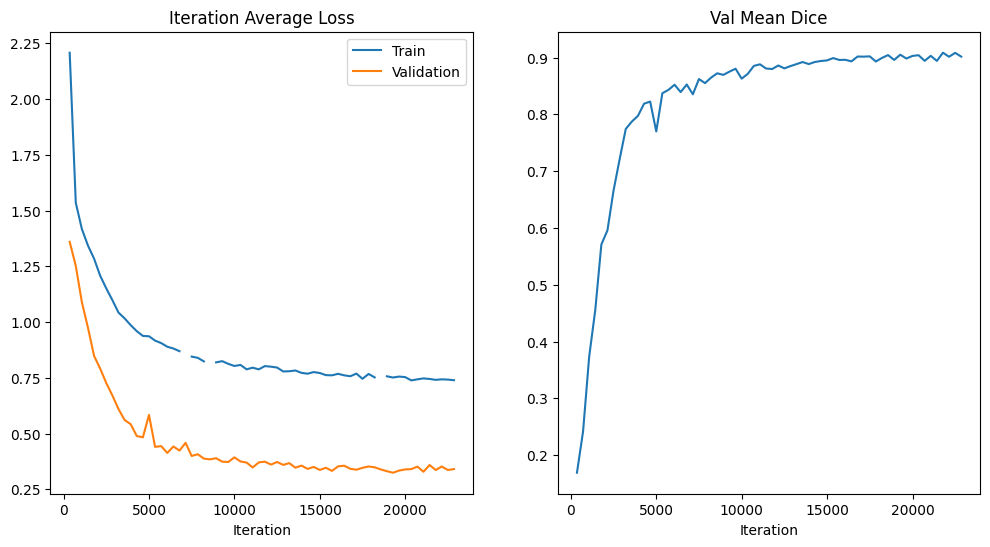

In [20]:
eval_num = 357
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y, label='Train')
x = [eval_num * (i + 1) for i in range(len(val_loss_values))]
y = val_loss_values
plt.plot(x, y, label='Validation')
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [21]:
model.load_state_dict(torch.load(model_name))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


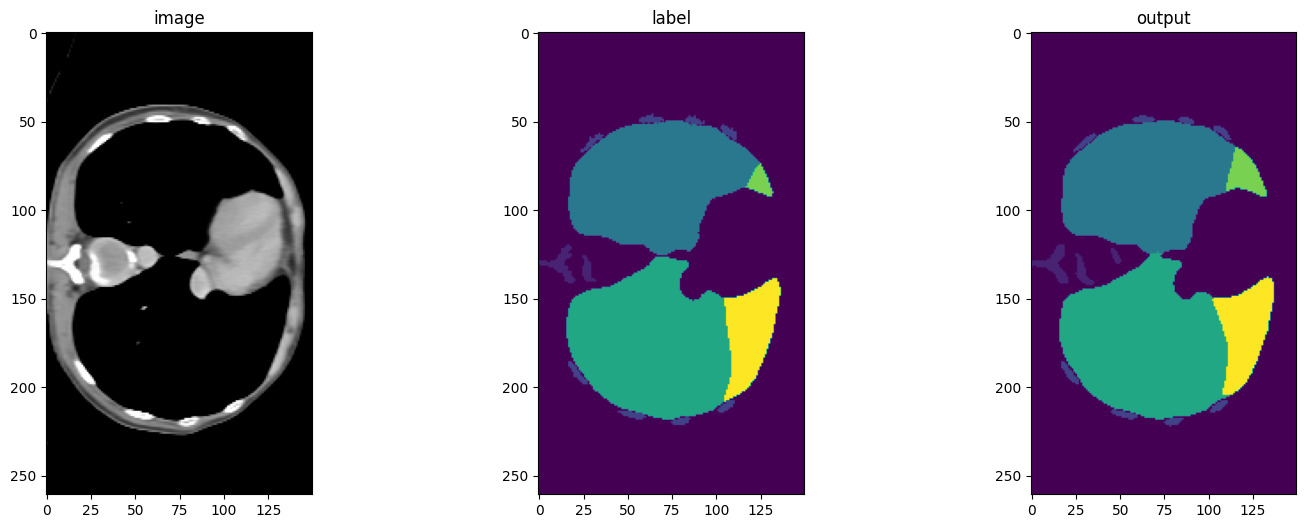

In [22]:
case_num = 4
with torch.no_grad():
    model.to('cpu')
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cpu()
    val_labels = torch.unsqueeze(label, 1).cpu()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), num_samples, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, 200], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, 200])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 200])
    plt.show()

In [23]:
file_list_test = generate_file_path(root_path=f'{root}/test')
test_ds = PersistentDataset(
    data=file_list_test,
    transform=val_transforms,
    cache_dir='test'
#     cache_dir='C:/Training/val'
)

test_loader = ThreadDataLoader(test_ds, num_workers=0, batch_size=1, 
                              collate_fn=lambda x: pad_list_data_collate(x, pad_to_shape=(96, 96, 96)))

In [24]:
def test(epoch_iterator_test):
    model.eval()
    test_loss = []
    with torch.no_grad():
        for batch in epoch_iterator_test:
            test_inputs, test_labels = (batch["image"].cpu(), batch["label"].cpu())
            with torch.cuda.amp.autocast():
#                 test_outputs = sliding_window_inference(test_inputs, (96, 96, 96), num_samples, model, overlap=0.8)
                test_outputs = sliding_window_inference(test_inputs, (96, 96, 96), num_samples, model)
            test_labels_list = decollate_batch(test_labels)
            test_labels_convert = [post_label(test_label_tensor) for test_label_tensor in test_labels_list]
            test_outputs_list = decollate_batch(test_outputs)
            test_output_convert = [post_pred(test_pred_tensor) for test_pred_tensor in test_outputs_list]
            loss = loss_function(test_outputs, test_labels)
            test_loss.append(loss.item())
            dice_metric(y_pred=test_output_convert, y=test_labels_convert)
            epoch_iterator_test.set_description(f"Test (loss={loss.item():2.5f})")
        mean_dice_test = dice_metric.aggregate().item()
        dice_metric.reset()

        test_loss_mean = np.nanmean(np.nan_to_num(np.array(test_loss),
                                               nan=np.nan, posinf=np.nan, neginf=np.nan))
    return mean_dice_test, test_loss_mean

In [25]:
epoch_iterator_test = tqdm(test_loader, desc="Test", dynamic_ncols=True)
dice_test, loss_test = test(epoch_iterator_test)

Test (loss=0.17631): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [05:42<00:00, 13.70s/it]


In [26]:
print(f'Test: (loss={loss_test}) (dice={dice_test})')

Test: (loss=0.18488451987504959) (dice=0.9018808007240295)
